In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa as lb
from scipy.fftpack import fft
import sounddevice as sd
from scipy.signal import hann

### 1. Frequency modulation sound synthesis (0.5 points)

In [2]:
fs = 16000   # Sampling rate
fc = 880     # Carrier frequency
fmod = 220   # Modulation frequency
amplitude = 1
I = 2        # Modulation index
duration = 1 # number of samples in signal

#### Create the signal, plot it and also its DFT spetrum

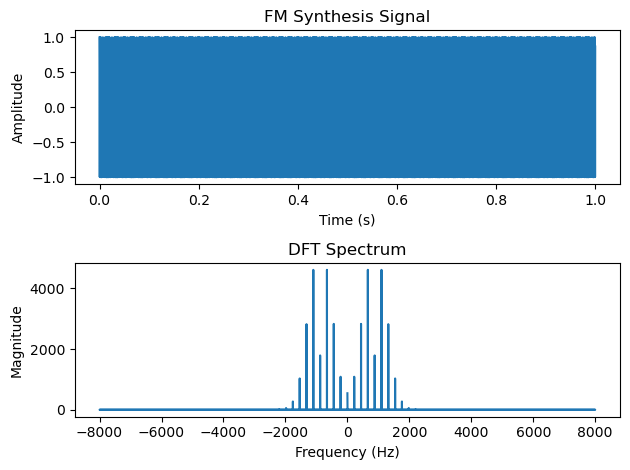

In [3]:

t = np.linspace(0, duration, int(fs * duration), endpoint=False)
carrier = amplitude * np.cos(2 * np.pi * fc * t + I * np.sin(2 * np.pi * fmod * t))
frequencies = np.fft.fftfreq(len(carrier), 1/fs)
dft = np.fft.fft(carrier)

plt.subplot(2, 1, 1)
plt.plot(t, carrier)
plt.title('FM Synthesis Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.plot(frequencies, np.abs(dft))
plt.title('DFT Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')

plt.tight_layout()
plt.show()


#### Play the sound

In [4]:
sd.play(carrier, fs)
sd.wait()

#### Auxiliary functions

In [5]:
def princarg(phase_in):
    """
    Computes principle argument,  wraps phase to (-pi, pi]
    """
    phase = np.mod(phase_in + np.pi,-2*np.pi)+np.pi;
    return phase
  

def delta_phi_(Phase_current, Phase_previous, winHopAn, wLen):
    """
    Function for calculating unwrapped phase difference between consecutive frames
    
    Phase_current: current frame phase
    Phase_previous: previous frame phase
    winHopAn: Analysis hop length
    wLen: window length
    """
    
    # nominal phase increment for the analysis hop size for each bin
    omega = 2*np.pi*(winHopAn/wLen)*np.arange(0, wLen)
    delta_phi = omega + princarg(Phase_current-Phase_previous-omega)
    
    return delta_phi

### 2. Implement a time stretching algorithm using phase vocoder. (1.5 points)

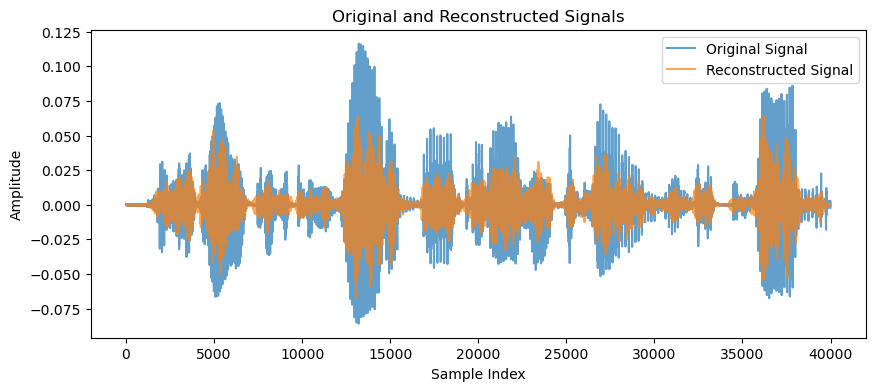

In [15]:
   
audioIn, fs = lb.load('audio.wav', sr=None)   # read audio

audioOut = np.zeros(len(audioIn))      # placeholder for reconstructed audio
wLen = int(0.032*fs)                   # window length
winAn = np.sqrt(hann(wLen, sym=False)) # analysis window
winSyn = winAn


winHopAn = int(0.008*fs)             # Hop length or frame advance
inInd = 0

R = 1.4 ; #winHopSyn / winHopAn;
#winHopAn = 8;
inInd = 0;
#prev_synthesis_phase = 0;

while inInd< len(audioIn)-wLen:
    # selct the frame and multiply with window function
    frame = audioIn[inInd:inInd+wLen]* winAn 

    # compute DFT
    f = fft(frame)

    # save magnitudes and phases
    mag_f = np.abs(f)
    phi0 = np.angle(f) 

    ####################
    # processing in spectral domain 
    #######################
    if inInd == 0:
        delta_phi = delta_phi_(phi0, np.zeros_like(phi0), winHopAn, wLen)
    else:
        delta_phi = delta_phi_(phi0, prev_analysis_phase, winHopAn, wLen)

    # Compute synthesis phase
    synthesis_phase = princarg(prev_synthesis_phase + R * delta_phi)
    # Recover the complex FFT back
    ft = mag_f * np.exp(1j * synthesis_phase)
      
    # inverse DFT and windowing
    frame = np.real(np.fft.ifft(ft)) * winSyn 

    # Ovelap add
    audioOut[inInd :inInd +wLen] =  audioOut[inInd :inInd +wLen] + frame
    prev_synthesis_phase = synthesis_phase
    prev_analysis_phase = phi0
    # frame advance by winHopAn
    inInd = inInd + winHopAn
    
plt.figure(figsize=(10, 4))
plt.plot(audioIn, label='Original Signal', alpha=0.7)
plt.plot(audioOut, label='Reconstructed Signal', alpha=0.7)
plt.title('Original and Reconstructed Signals')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [11]:
sd.play(audioIn, fs)

In [12]:
sd.play(audioOut, fs)

### Bonus question: Add pitch shifting